Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Pré-treinando BERT
:label:`sec_bert-pretraining`

Com o modelo BERT implementado em: numref: `sec_bert` e os exemplos de pré-treinamento gerados a partir do conjunto de dados WikiText-2 em :numref:`sec_bert-dataset`, iremos pré-treinar o BERT no conjunto de dados WikiText-2 nesta seção.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

Para começar, carregamos o conjunto de dados WikiText-2 como minibatches de exemplos de pré-treinamento para modelagem de linguagem mascarada e previsão da próxima frase. O tamanho do lote é 512 e o comprimento máximo de uma sequência de entrada de BERT é 64. Observe que no modelo BERT original, o comprimento máximo é 512.


In [2]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

## Pré-treinamento de BERT

O BERT original tem duas versões de tamanhos de modelo diferentes :cite:`Devlin.Chang.Lee.ea.2018`.
O modelo base ($\text{BERT}_{\text{BASE}}$) usa 12 camadas (blocos codificadores do transformador)
com 768 unidades ocultas (tamanho oculto) e 12 cabeças de autoatenção.
O modelo grande ($\text{BERT}_{\text{LARGE}}$) usa 24 camadas
com 1024 unidades ocultas e 16 cabeças de autoatenção.
Notavelmente, o primeiro tem 110 milhões de parâmetros, enquanto o último tem 340 milhões de parâmetros.
Para demonstração com facilidade,
definimos um pequeno BERT, usando 2 camadas, 128 unidades ocultas e 2 cabeças de autoatenção.


In [3]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

Antes de definir o ciclo de treinamento,
definimos uma função auxiliar `_get_batch_loss_bert`.
Dado o fragmento de exemplos de treinamento,
esta função calcula a perda tanto para a modelagem de linguagem mascarada quanto para as tarefas de previsão da próxima frase.
Observe que a perda final do pré-treinamento de BERT
é apenas a soma da perda de modelagem de linguagem mascarada
e a próxima perda de previsão de frase.


In [4]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

Invocando as duas funções auxiliares mencionadas,
a seguinte função `train_bert`
define o procedimento para pré-treinar BERT (`net`) no conjunto de dados WikiText-2 (`train_iter`).
Treinar o BERT pode demorar muito.
Em vez de especificar o número de épocas para treinamento
como na função `train_ch13` (veja :numref:`sec_image_augmentation`),
a entrada `num_steps` da seguinte função
especifica o número de etapas de iteração para treinamento.


In [5]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=1e-3)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

Podemos representar graficamente a perda de modelagem de linguagem mascarada e a perda de previsão da próxima frase
durante o pré-treinamento de BERT.


MLM loss 6.190, NSP loss 0.697
2947.7 sentence pairs/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


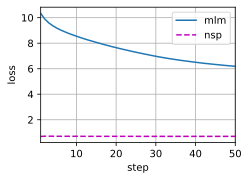

In [6]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

## Representando Texto com BERT

Após o pré-treinamento de BERT,
podemos usá-lo para representar um único texto, pares de texto ou qualquer token neles.
A função a seguir retorna as representações BERT (`net`) para todos os tokens
em `tokens_a` e` tokens_b`.


In [7]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

Considere a frase "um guindaste está voando".
Lembre-se da representação de entrada de BERT conforme discutido em :numref:`subsec_bert_input_rep`.
Após inserir tokens especiais “&lt;cls&gt;” (usado para classificação)
e “&lt;cls&gt;” (usado para separação),
a sequência de entrada de BERT tem um comprimento de seis.
Uma vez que zero é o índice de “&lt;cls&gt;” símbolo,
`encoded_text[:, 0, :]` é a representação BERT de toda a sentença de entrada.
Para avaliar o token de polissemia "guindaste",
também imprimimos os três primeiros elementos da representação BERT do token.


In [8]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-1.4874, -0.0197, -1.0948], device='cuda:0', grad_fn=<SliceBackward>))

Agora considere um par de frases
"veio um motorista de guindaste" e "acabou de sair".
Da mesma forma, `encoded_pair[:, 0, :]` é o resultado codificado de todo o par de frases do BERT pré-treinado.
Observe que os três primeiros elementos do token de polissemia "guindaste" são diferentes daqueles quando o contexto é diferente.
Isso sustenta que as representações de BERT são sensíveis ao contexto.


In [9]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-1.3744, -0.7841, -1.4191], device='cuda:0', grad_fn=<SliceBackward>))

Em :numref:`chap_nlp_app`, vamos ajustar um modelo BERT pré-treinado
para aplicativos de processamento de linguagem natural downstream.


## Sumário

* O BERT original tem duas versões, onde o modelo básico tem 110 milhões de parâmetros e o modelo grande tem 340 milhões de parâmetros.
* Após o pré-treinamento de BERT, podemos usá-lo para representar texto único, pares de texto ou qualquer token neles.
* No experimento, o mesmo token tem diferentes representações de BERT quando seus contextos são diferentes. Isso sustenta que as representações de BERT são sensíveis ao contexto.

## Exercícios

1. No experimento, podemos ver que a perda de modelagem da linguagem mascarada é significativamente maior do que a perda de previsão da próxima frase. Por quê?
2. Defina o comprimento máximo de uma sequência de entrada de BERT como 512 (igual ao modelo de BERT original). Use as configurações do modelo BERT original como $\text{BERT}_{\text{LARGE}}$. Você encontra algum erro ao executar esta seção? Por quê?


[Discussão](https://discuss.d2l.ai/t/1497)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTE5MDE5NjMzOTBdfQ==
-->
